In [28]:
# imports
import pandas as pd
import numpy as np
from nltk import ngrams
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from nltk import FreqDist
from sklearn.metrics import accuracy_score

In [2]:
# read file tokenized_eng_balanced
tokenized_nationality_eng = pd.read_csv("data/tokenized_eng_balanced.csv")
tokenized_nationality_eng.head(10)

,Poles,tokens,eng_tokens,average_word_length,avg_sentence_length,ttr,ner,norm_.,"norm_,",norm_?,norm_!,topic_distributions
0,Western,"['[""[\'is\',"",', '\'""n\\\'t"",\',', '""\',\',"",'...","[""'is'"", ""'n'"", ""'t'"", ""'show'"", ""'legally'"", ...",5.744459,50.730000,0.676662,"[('uk us', 'PERSON'), ('two', 'CARDINAL'), ('o...",0.125163,0.035202,0.015645,0.003911,"[(25, 0.8116855), (27, 0.18461613)]"
1,Western,"['[""[\'game\',"",', '""\'game\',"",', '""\'played\...","[""'game'"", ""'game'"", ""'game'"", ""'calculated'"",...",5.815094,50.113208,0.680503,"[('half', 'CARDINAL'), ('0.5', 'CARDINAL'), ('...",0.135849,0.027673,0.013836,0.003774,"[(10, 0.03548529), (25, 0.75914997), (27, 0.20..."
2,Western,"['[""[\'logic\',"",', '""\'usa\',"",', '""\'shitty\...","[""'logic'"", ""'place'"", ""'live'"", ""'with'"", ""'s...",5.732911,55.585106,0.681013,"[('logic usa shitty place', 'ORG'), ('million'...",0.111392,0.041772,0.012658,0.005063,"[(25, 0.9813763), (27, 0.017674072)]"
3,Western,"['[""[\'referring\',"",', '""\'add\',"",', '""\'lot...","[""'add'"", ""'lot'"", ""'ea'"", ""'re'"", ""'release'""...",5.890951,48.915966,0.661253,"[('year', 'DATE'), ('kyllä', 'ORG'), ('tuntuu ...",0.132251,0.039443,0.022042,0.022042,"[(10, 0.07604084), (25, 0.42412332), (27, 0.49..."
4,Western,"['[""[\'get\',"",', '""\'another\',"",', '""\'role\...","[""'get'"", ""'another'"", ""'role'"", ""'support'"", ...",5.804756,48.880734,0.685857,"[('23', 'CARDINAL'), ('22', 'CARDINAL'), ('and...",0.125156,0.027534,0.010013,0.002503,"[(10, 0.010025548), (25, 0.6885383), (27, 0.30..."
5,Western,"['[""[\'income\',"",', '""\'land\',"",', '""\'(\',""...","[""'income'"", ""'land'"", ""'government'"", ""'pay'""...",5.690073,51.132075,0.676755,"[('wich government', 'ORG'), ('two', 'CARDINAL...",0.130751,0.038741,0.007264,0.006053,"[(25, 0.95574784), (27, 0.04336619)]"
6,Western,"['[""[\'majority\',"",', '""\'people\',"",', '""\'d...","[""'majority'"", ""'people'"", ""'direct'"", ""'benef...",5.693569,43.983051,0.725095,"[('100%', 'PERCENT'), ('one', 'CARDINAL'), ('5...",0.136192,0.034048,0.023960,0.006305,"[(10, 0.16374189), (25, 0.8176976), (27, 0.017..."
7,Western,"['[""[\'footage\',"",', '""\'nah\',"",', '""\'.\',""...","[""'footage'"", ""'use'"", ""'brand'"", ""'us'"", ""'st...",5.811881,58.826087,0.696782,"[('android', 'ORG'), ('android', 'ORG'), ('bul...",0.097772,0.021040,0.017327,0.009901,"[(10, 0.25310677), (25, 0.64492977), (27, 0.10..."
8,Western,"['[""[\'alien\',"",', '""\'christians\',"",', '""\'...","[""'alien'"", ""'yes'"", ""'yes'"", ""'yes'"", ""'resul...",5.540705,60.170455,0.654921,"[('christians', 'NORP'), ('&gt', 'ORG'), ('2',...",0.092345,0.029162,0.014581,0.008505,"[(10, 0.030134538), (25, 0.65420467), (27, 0.3..."
9,Western,"['[""[\'that\',"",', '\'""\\\'s"",\',', '""\'glued\...","[""'that'"", ""'s'"", ""'glued'"", ""'outside'"", ""'pr...",5.660099,44.830508,0.701970,"[('one', 'CARDINAL'), ('ehhhh', 'LOC'), ('300'...",0.129310,0.019704,0.025862,0.006158,"[(10, 0.053916052), (25, 0.7771401), (27, 0.16..."


In [3]:
for col in tokenized_nationality_eng.columns:
    print(col)

Poles
tokens
eng_tokens
average_word_length
avg_sentence_length
ttr
ner
norm_.
norm_,
norm_?
norm_!
topic_distributions


#### Trying with SNEHA's Balanced dataset with approx 15K per pole

In [29]:
# read file SNEHA'S balanced dataset (approx 15K per pole)
tokenized_nationality_balanced = pd.read_csv("data/Undersampled_balanced_data.csv")
tokenized_nationality_balanced.head(10)

,auhtor_ID,post,nationality,Poles,tokens,eng_tokens,average_word_length,avg_sentence_length,ttr,ner,norm_.,"norm_,",norm_?,norm_!,topic_distributions,nr_unique_words,nr_chars,nr_contradictions,subjectivity
0,t2_ffcfiueh,course people look hyperbolic one racism bad e...,Norway,Western,"['[""[\'course\',"",', '""\'people\',"",', '""\'loo...","[""'course'"", ""'people'"", ""'look'"", ""'hyperboli...",5.481442,66.164835,0.707317,"[('one', 'CARDINAL'), ('bkb', 'ORG'), ('hundre...",0.091198,0.047720,0.006363,0.007423,"[(6, 0.27886572), (10, 0.17313653), (25, 0.319...",667,6111,6,0.485495
1,t2_lfs48,police drag foot it/come different conclusion ...,Germany,Western,"['[""[\'police\',"",', '""\'drag\',"",', '""\'foot\...","[""'police'"", ""'drag'"", ""'foot'"", ""'it'"", ""'com...",6.285714,85.014925,0.718078,"[('anmeldung', 'GPE'), ('berlin', 'GPE'), ('fi...",0.113780,0.078382,0.002528,0.000000,"[(25, 0.72906566), (27, 0.26771897)]",568,5762,17,0.487030
2,t2_zcj4y,nice curves. really pretty. maybe i'm 'oldscho...,The Netherlands,Western,"['[""[\'nice\',"",', '""\'curves\',"",', '""\'.\',""...","[""'nice'"", ""'really'"", ""'pretty'"", ""'maybe'"", ...",5.580460,34.134969,0.747126,"[('lootboxes', 'NORP'), ('1', 'CARDINAL'), (""1...",0.174713,0.065517,0.021839,0.010345,"[(5, 0.067286186), (10, 0.1327022), (25, 0.799...",650,5724,18,0.551005
3,t2_2xpu7n1c,action try manufacture result make “good” tv. ...,United Kingdom,Western,"['[""[\'action\',"",', '""\'try\',"",', '""\'manufa...","[""'action'"", ""'try'"", ""'manufacture'"", ""'resul...",5.481297,75.441176,0.640898,"[('lewis', 'PERSON'), ('max', 'PERSON'), ('max...",0.073566,0.112219,0.009975,0.002494,"[(10, 0.286261), (25, 0.7099816)]",514,5197,0,0.514366
4,t2_3edl7,"location, altitude, speed, direction every dji...",Germany,Western,"['[""[\'location\',"",', '""\',\',"",', '""\'altitu...","[""'location'"", ""'altitude'"", ""'speed'"", ""'dire...",5.916865,60.968085,0.719715,"[('dji', 'PRODUCT'), ('30 miles', 'QUANTITY'),...",0.122328,0.085511,0.005938,0.001188,"[(3, 0.019032711), (25, 0.04007173), (27, 0.93...",606,5823,11,0.401854
5,t2_r4dta,far iptv. lot trial error finally found config...,Germany,Western,"['[""[\'far\',"",', '""\'iptv\',"",', '""\'.\',"",',...","[""'far'"", ""'lot'"", ""'trial'"", ""'error'"", ""'fin...",5.458732,83.477273,0.651607,"[('around 95%', 'PERCENT'), ('two', 'CARDINAL'...",0.083406,0.046047,0.006950,0.004344,"[(3, 0.68141955), (25, 0.28099504), (27, 0.036...",750,7433,10,0.505461
6,t2_8oq1onsp,19th century? i'm first come criticising germa...,Germany,Western,"['[""[\'19th\',"",', '""\'century\',"",', '""\'?\',...","[""'th'"", ""'century'"", ""'i'"", ""'m'"", ""'first'"",...",6.331250,54.857143,0.732500,"[('19th century', 'DATE'), ('first', 'ORDINAL'...",0.117500,0.068750,0.017500,0.000000,"[(10, 0.19710149), (25, 0.014830774), (27, 0.7...",586,5864,11,0.463771
7,t2_ohefx,read theory. i'm sure learn difference univers...,Denmark,Western,"['[""[\'read\',"",', '""\'theory\',"",', '""\'.\',""...","[""'read'"", ""'theory'"", ""'i'"", ""'m'"", ""'sure'"",...",4.929730,66.163265,0.589189,"[('america', 'GPE'), ('europe', 'LOC'), ('amer...",0.098198,0.042342,0.010811,0.000000,"[(6, 0.6443614), (10, 0.17756967), (25, 0.0357...",654,6581,9,0.473738
8,t2_kd2lsk,i'd say probably - maybe racist - bias. can't ...,France,Western,"['[""[\'i\',"",', '\'""\\\'d"",\',', '""\'say\',"",'...","[""'i'"", ""'d'"", ""'say'"", ""'probably'"", ""'maybe'...",5.734149,107.107143,0.751947,"[('french', 'NORP'), ('5 year', 'DATE'), ('aus...",0.055617,0.094549,0.008899,0.004449,"[(10, 0.23158021), (16, 0.11595541), (25, 0.60...",676,6053,24,0.497906
9,t2_y77lc,another. ai text recognition also better human...,Finland,Western,"['[""[\'another\',"",', '""\'.\',"",', '""\'ai\',"",...","[""'another'"", ""'ai'"", ""'text'"", ""'recognition'...",5.554726,55.666667,0.671642,"[('one', 'CARDINAL'), ('first', 'ORDINAL'), ('...",0.113184,0.078358,0.002488,0.000000,"[(25, 0.9238123), (27, 0.06894950

Create a new column for bi-grams

In [4]:
# Function to create bi-grams from a list of tokens
def generate_bi_grams(tokens):
    return list(ngrams(tokens, 2))

# Apply the bi-gram extraction to the 'eng_tokens' column
tokenized_nationality_eng['bi_grams'] = tokenized_nationality_eng['eng_tokens'].apply(lambda x: generate_bi_grams(literal_eval(x)))

# Display the resulting DataFrame
print(tokenized_nationality_eng[['Poles', 'eng_tokens', 'bi_grams']])

         Poles                                         eng_tokens  \
0      Western  ["'is'", "'n'", "'t'", "'show'", "'legally'", ...   
1      Western  ["'game'", "'game'", "'game'", "'calculated'",...   
2      Western  ["'logic'", "'place'", "'live'", "'with'", "'s...   
3      Western  ["'add'", "'lot'", "'ea'", "'re'", "'release'"...   
4      Western  ["'get'", "'another'", "'role'", "'support'", ...   
...        ...                                                ...   
68754  Western  ["'sergeant'", "'york'", "'lend'", "'it'", "'s...   
68755  Western  ["'position'", "'person'", "'get'", "'short'",...   
68756  Western  ["'read'", "'label'", "'high'", "'red'", "'mea...   
68757  Western  ["'suggesting'", "'treason'", "'treason'", "'d...   
68758  Western  ["'drug'", "'trade'", "'staffed'", "'benefit'"...   

                                                bi_grams  
0      [('is', 'n'), ('n', 't'), ('t', 'show'), ('sho...  
1      [('game', 'game'), ('game', 'game'), ('game', 

#### Trying with SNEHA's Balanced dataset with approx 15K per pole

In [30]:
# Function to create bi-grams from a list of tokens
def generate_bi_grams(tokens):
    return list(ngrams(tokens, 2))

# Apply the bi-gram extraction to the 'eng_tokens' column
tokenized_nationality_balanced['bi_grams'] = tokenized_nationality_balanced['eng_tokens'].apply(lambda x: generate_bi_grams(literal_eval(x)))

# Display the resulting DataFrame
print(tokenized_nationality_balanced[['Poles', 'eng_tokens', 'bi_grams']])

         Poles                                         eng_tokens  \
0      Western  ["'course'", "'people'", "'look'", "'hyperboli...   
1      Western  ["'police'", "'drag'", "'foot'", "'it'", "'com...   
2      Western  ["'nice'", "'really'", "'pretty'", "'maybe'", ...   
3      Western  ["'action'", "'try'", "'manufacture'", "'resul...   
4      Western  ["'location'", "'altitude'", "'speed'", "'dire...   
...        ...                                                ...   
30937  Eastern  ["'raid'", "'good'", "'hunt'", "'mean'", "'gov...   
30938  Eastern  ["'homemade'", "'one'", "'kill'", "'people'", ...   
30939  Eastern  ["'head'", "'look'", "'like'", "'imperialism'"...   
30940  Eastern  ["'purgatory'", "'help'", "'soul'", "'get'", "...   
30941  Eastern  ["'claim'", "'talking'", "'ca'", "'even'", "'e...   

                                                bi_grams  
0      [('course', 'people'), ('people', 'look'), ('l...  
1      [('police', 'drag'), ('drag', 'foot'), ('foot'

### Frequency distribution for bi-grams column:

In [8]:
# Extract bigrams from the 'bi_grams' column
all_bigrams = [bigram for sublist in tokenized_nationality_eng['bi_grams'] for bigram in sublist]

# Calculate the frequency distribution of bigrams
bigram_freq_dist = FreqDist(all_bigrams)

# Display a subset of bigrams and their frequencies
print("\nBigram Frequency Distribution (Top 30):")
print(bigram_freq_dist.most_common(30))  # Displaying the top 30 bigrams


Bigram Frequency Distribution (Top 30):
[(("'i'", "'m'"), 214197), (("'n'", "'t'"), 207335), (("'that'", "'s'"), 173755), (("'ca'", "'n'"), 87421), (("'there'", "'s'"), 65365), (("'it'", "'s'"), 63546), (("'they'", "'re'"), 61161), (("'i'", "'d'"), 51217), (("'do'", "'n'"), 43706), (("'he'", "'s'"), 42433), (("'de'", "'de'"), 25043), (("'look'", "'like'"), 23542), (("'what'", "'s'"), 22610), (("'we'", "'re'"), 22347), (("'gon'", "'na'"), 18848), (("'de'", "'la'"), 17904), (("'feel'", "'like'"), 17737), (("'m'", "'sure'"), 17467), (("'year'", "'ago'"), 16404), (("'make'", "'sense'"), 16296), (("'you'", "'re'"), 15874), (("'can'", "'not'"), 15524), (("'die'", "'die'"), 15361), (("'x'", "'b'"), 15241), (("'sound'", "'like'"), 14954), (("'let'", "'s'"), 14844), (("'does'", "'n'"), 14731), (("'da'", "'ist'"), 14108), (("'pretty'", "'much'"), 14105), (("'did'", "'n'"), 13546)]


#### Output:
The first entry ("'i'", "'m'") has a frequency of 214,197, indicating that the bigram "I'm" appears that many times in your dataset.
Can also explore patterns in language usage. For instance, the bigram "'do'", "'n'" suggests contractions like "don't," and "'can'", "'not'" indicates "can't." Understanding these patterns can help in language analysis.

#### Trying with SNEHA's Balanced dataset 

In [31]:
# Extract bigrams from the 'bi_grams' column and store in all_bigrams_balanced
all_bigrams_balanced = [bigram for sublist in tokenized_nationality_balanced['bi_grams'] for bigram in sublist]

# Calculate the frequency distribution of bigrams
bigram_freq_dist_balanced = FreqDist(all_bigrams_balanced)

# Display a subset of bigrams and their frequencies
print("\nBigram Frequency Distribution for tokenized_nationality_balanced (Top 30):")
print(bigram_freq_dist_balanced.most_common(30))  # Displaying the top 30 bigrams


Bigram Frequency Distribution for tokenized_nationality_balanced (Top 30):
[(("'i'", "'m'"), 93275), (("'n'", "'t'"), 90366), (("'that'", "'s'"), 76212), (("'ca'", "'n'"), 38775), (("'it'", "'s'"), 27552), (("'there'", "'s'"), 26681), (("'they'", "'re'"), 24016), (("'i'", "'d'"), 21070), (("'do'", "'n'"), 19119), (("'he'", "'s'"), 17795), (("'look'", "'like'"), 10871), (("'de'", "'de'"), 10118), (("'what'", "'s'"), 10055), (("'we'", "'re'"), 9407), (("'gon'", "'na'"), 8859), (("'de'", "'la'"), 8011), (("'feel'", "'like'"), 7868), (("'x'", "'b'"), 7601), (("'year'", "'ago'"), 7375), (("'m'", "'sure'"), 7369), (("'make'", "'sense'"), 7176), (("'can'", "'not'"), 7108), (("'let'", "'s'"), 6857), (("'does'", "'n'"), 6507), (("'you'", "'re'"), 6488), (("'pretty'", "'much'"), 6339), (("'sound'", "'like'"), 6330), (("'did'", "'n'"), 5925), (("'like'", "'that'"), 5775), (("'da'", "'se'"), 5648)]


### Compare the frequency of the top 30 bi-grams for eastern and western 

In [16]:
# Create separate datasets for Eastern and Western poles
eastern_data = tokenized_nationality_eng[tokenized_nationality_eng['Poles'] == 'Eastern']
western_data = tokenized_nationality_eng[tokenized_nationality_eng['Poles'] == 'Western']

# Extract bigrams for Eastern poles
eastern_bigrams = [bigram for sublist in eastern_data['bi_grams'] for bigram in sublist]
eastern_bigram_freq_dist = FreqDist(eastern_bigrams)

# Extract bigrams for Western poles
western_bigrams = [bigram for sublist in western_data['bi_grams'] for bigram in sublist]
western_bigram_freq_dist = FreqDist(western_bigrams)

# Get the top 30 bigrams for each pole
top30_eastern_bigrams = eastern_bigram_freq_dist.most_common(30)
top30_western_bigrams = western_bigram_freq_dist.most_common(30)

# Convert bigram tuples to strings
top30_eastern_bigrams_str = [f"{bigram[0]} {bigram[1]}" for bigram, _ in top30_eastern_bigrams]
top30_western_bigrams_str = [f"{bigram[0]} {bigram[1]}" for bigram, _ in top30_western_bigrams]


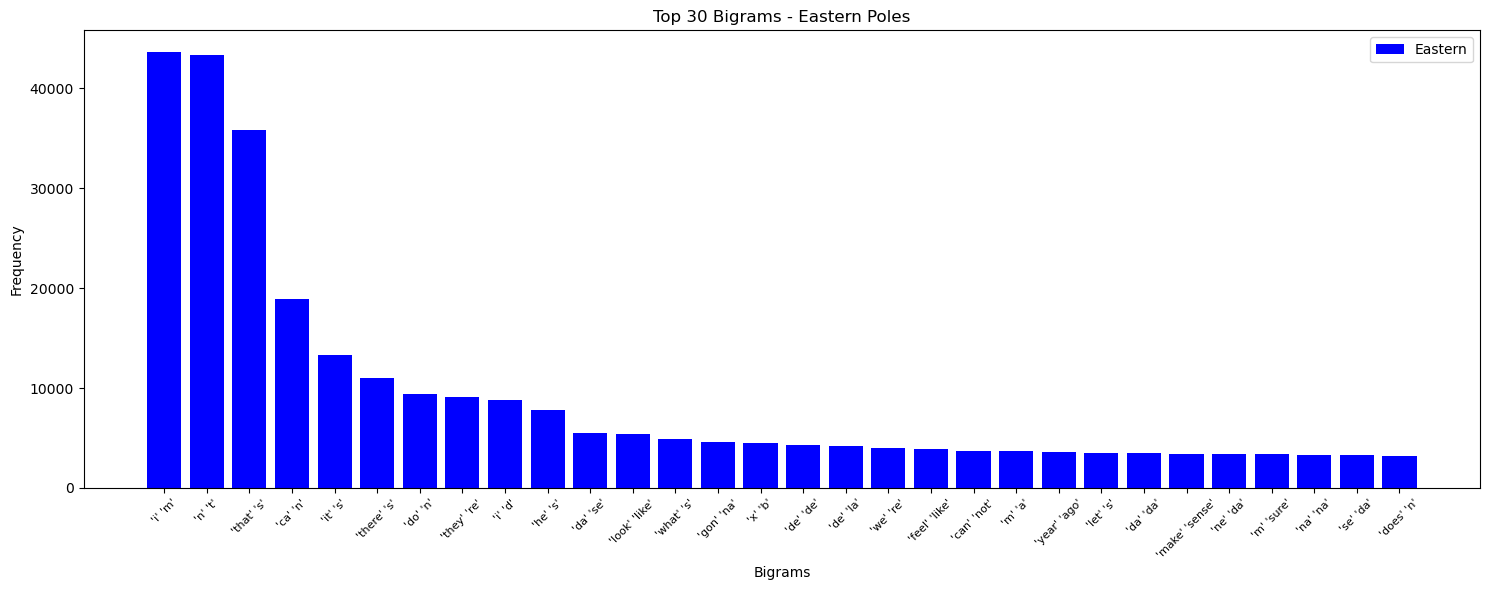

In [17]:
# Visualize the comparison for Eastern poles (bar chart)
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(top30_eastern_bigrams_str, [freq for _, freq in top30_eastern_bigrams], color='blue', label='Eastern')

# Set plot labels and title
ax.set_xlabel('Bigrams')
ax.set_ylabel('Frequency')
ax.set_title('Top 30 Bigrams - Eastern Poles')
ax.tick_params(axis='x', rotation=45, labelsize=8)

# Display legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

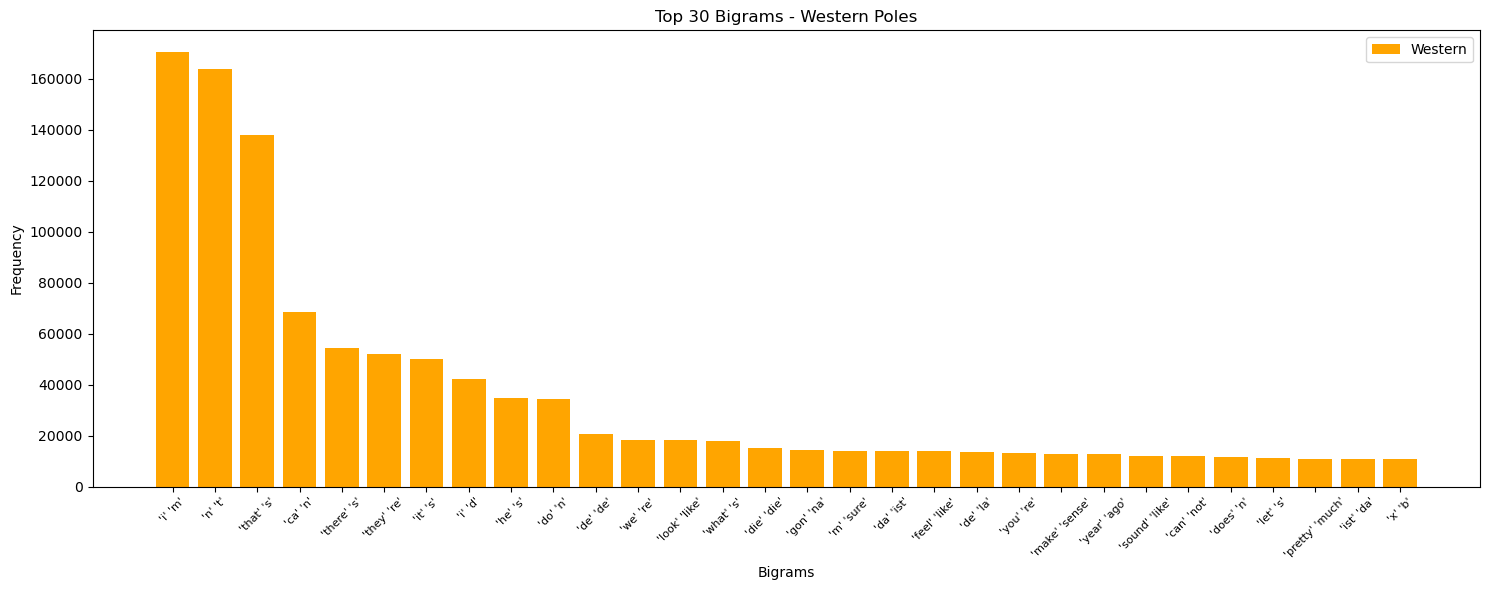

In [18]:
# Visualize the comparison for Western poles (bar chart)
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(top30_western_bigrams_str, [freq for _, freq in top30_western_bigrams], color='orange', label='Western')

# Set plot labels and title
ax.set_xlabel('Bigrams')
ax.set_ylabel('Frequency')
ax.set_title('Top 30 Bigrams - Western Poles')
ax.tick_params(axis='x', rotation=45, labelsize=8)

# Display legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [19]:
## Print the top 30 bi-grams for eastern and western users:
print('top30_eastern_bigrams: ')
print(top30_eastern_bigrams)
print('top30_western_bigrams: ')
print(top30_western_bigrams)

top30_eastern_bigrams: 
[(("'i'", "'m'"), 43630), (("'n'", "'t'"), 43301), (("'that'", "'s'"), 35863), (("'ca'", "'n'"), 18863), (("'it'", "'s'"), 13302), (("'there'", "'s'"), 10990), (("'do'", "'n'"), 9367), (("'they'", "'re'"), 9078), (("'i'", "'d'"), 8845), (("'he'", "'s'"), 7800), (("'da'", "'se'"), 5509), (("'look'", "'like'"), 5434), (("'what'", "'s'"), 4857), (("'gon'", "'na'"), 4633), (("'x'", "'b'"), 4516), (("'de'", "'de'"), 4307), (("'de'", "'la'"), 4228), (("'we'", "'re'"), 3972), (("'feel'", "'like'"), 3905), (("'can'", "'not'"), 3677), (("'m'", "'a'"), 3665), (("'year'", "'ago'"), 3622), (("'let'", "'s'"), 3532), (("'da'", "'da'"), 3469), (("'make'", "'sense'"), 3431), (("'ne'", "'da'"), 3418), (("'m'", "'sure'"), 3386), (("'na'", "'na'"), 3337), (("'se'", "'da'"), 3303), (("'does'", "'n'"), 3234)]
top30_western_bigrams: 
[(("'i'", "'m'"), 170567), (("'n'", "'t'"), 164034), (("'that'", "'s'"), 137892), (("'ca'", "'n'"), 68558), (("'there'", "'s'"), 54375), (("'they'", "'r

### Trying the same with Sneha's dataset:

In [32]:
# Create separate datasets for Eastern and Western poles
eastern_data_balanced = tokenized_nationality_balanced[tokenized_nationality_balanced['Poles'] == 'Eastern']
western_data_balanced = tokenized_nationality_balanced[tokenized_nationality_balanced['Poles'] == 'Western']

# Extract bigrams for Eastern poles
eastern_bigrams_balanced = [bigram for sublist in eastern_data_balanced['bi_grams'] for bigram in sublist]
eastern_bigram_freq_dist_balanced = FreqDist(eastern_bigrams_balanced)

# Extract bigrams for Western poles
western_bigrams_balanced = [bigram for sublist in western_data_balanced['bi_grams'] for bigram in sublist]
western_bigram_freq_dist_balanced = FreqDist(western_bigrams_balanced)

# Get the top 30 bigrams for each pole
top30_eastern_bigrams_balanced = eastern_bigram_freq_dist_balanced.most_common(30)
top30_western_bigrams_balanced = western_bigram_freq_dist_balanced.most_common(30)

# Convert bigram tuples to strings
top30_eastern_bigrams_balanced_str = [f"{bigram[0]} {bigram[1]}" for bigram, _ in top30_eastern_bigrams_balanced]
top30_western_bigrams_balanced_str = [f"{bigram[0]} {bigram[1]}" for bigram, _ in top30_western_bigrams_balanced]


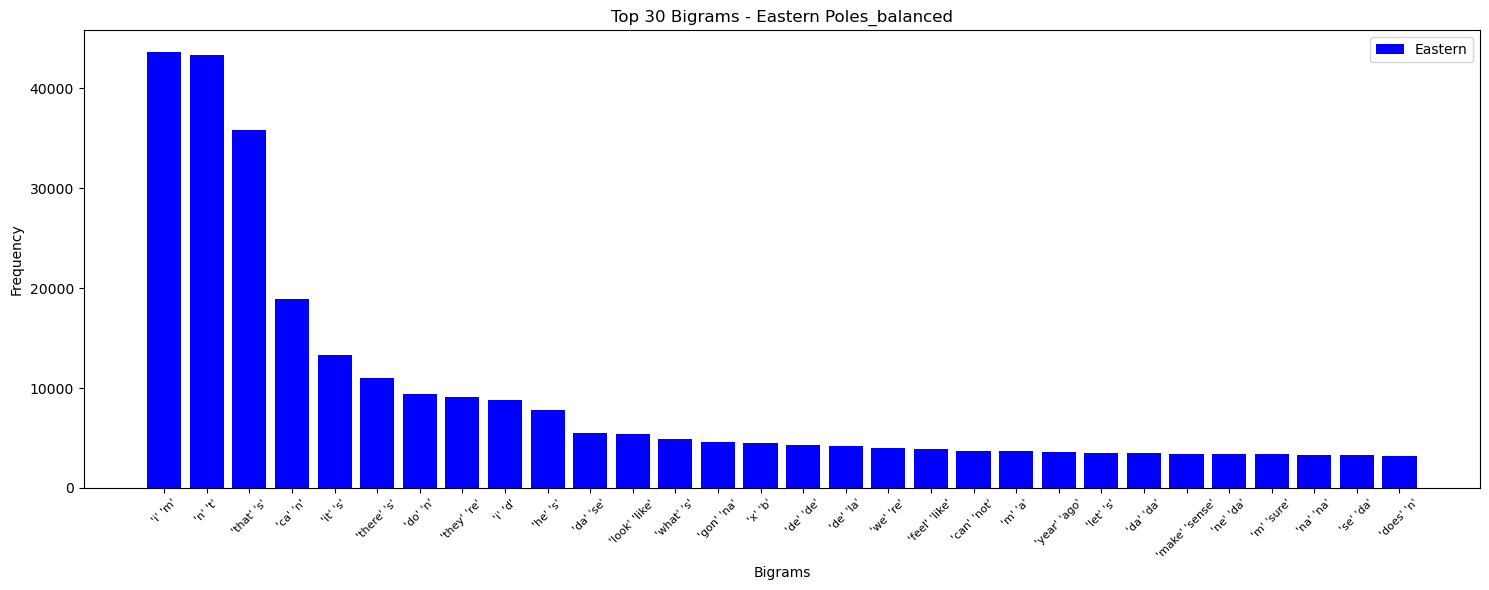

In [33]:
# Visualize the comparison for Eastern poles (bar chart)
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(top30_eastern_bigrams_balanced_str, [freq for _, freq in top30_eastern_bigrams_balanced], color='blue', label='Eastern')

# Set plot labels and title
ax.set_xlabel('Bigrams')
ax.set_ylabel('Frequency')
ax.set_title('Top 30 Bigrams - Eastern Poles_balanced')
ax.tick_params(axis='x', rotation=45, labelsize=8)

# Display legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

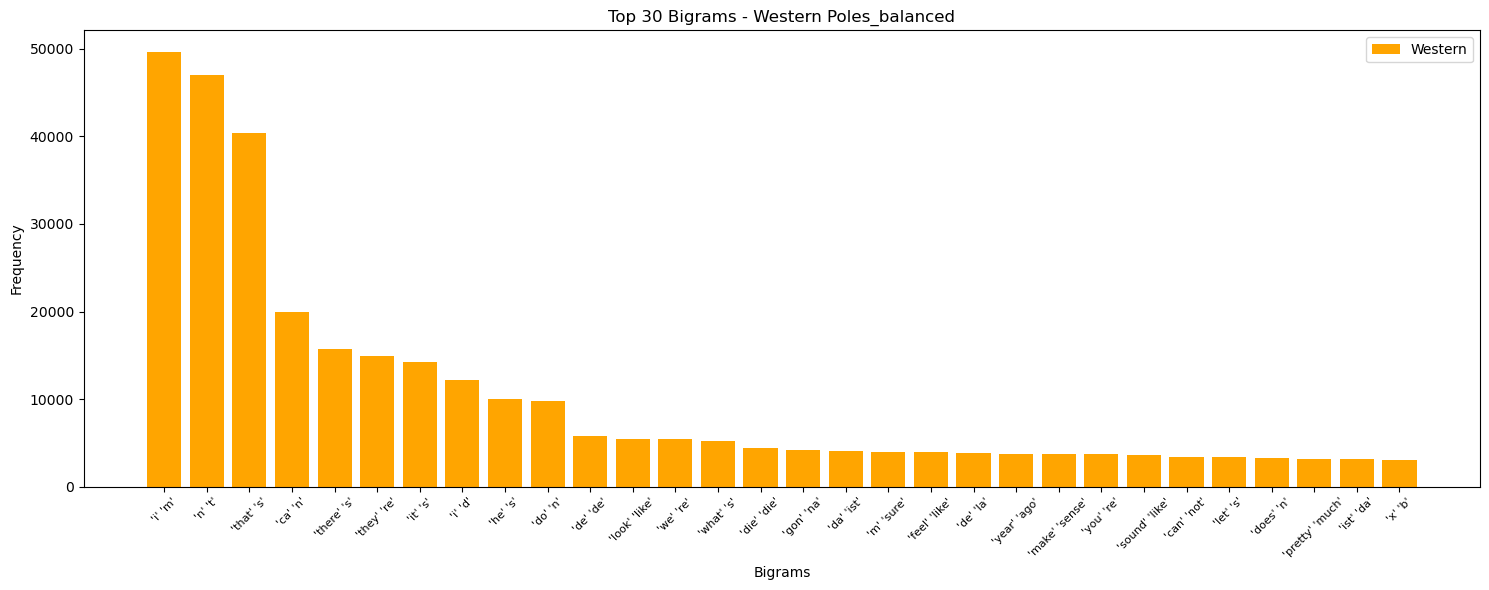

In [34]:
# Visualize the comparison for Western poles (bar chart)
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(top30_western_bigrams_balanced_str, [freq for _, freq in top30_western_bigrams_balanced], color='orange', label='Western')

# Set plot labels and title
ax.set_xlabel('Bigrams')
ax.set_ylabel('Frequency')
ax.set_title('Top 30 Bigrams - Western Poles_balanced')
ax.tick_params(axis='x', rotation=45, labelsize=8)

# Display legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [35]:
## Print the top 30 bi-grams for eastern and western users:
print('top30_eastern_bigrams: ')
print(top30_eastern_bigrams_balanced)
print('top30_western_bigrams: ')
print(top30_western_bigrams_balanced)

top30_eastern_bigrams: 
[(("'i'", "'m'"), 43630), (("'n'", "'t'"), 43301), (("'that'", "'s'"), 35863), (("'ca'", "'n'"), 18863), (("'it'", "'s'"), 13302), (("'there'", "'s'"), 10990), (("'do'", "'n'"), 9367), (("'they'", "'re'"), 9078), (("'i'", "'d'"), 8845), (("'he'", "'s'"), 7800), (("'da'", "'se'"), 5509), (("'look'", "'like'"), 5434), (("'what'", "'s'"), 4857), (("'gon'", "'na'"), 4633), (("'x'", "'b'"), 4516), (("'de'", "'de'"), 4307), (("'de'", "'la'"), 4228), (("'we'", "'re'"), 3972), (("'feel'", "'like'"), 3905), (("'can'", "'not'"), 3677), (("'m'", "'a'"), 3665), (("'year'", "'ago'"), 3622), (("'let'", "'s'"), 3532), (("'da'", "'da'"), 3469), (("'make'", "'sense'"), 3431), (("'ne'", "'da'"), 3418), (("'m'", "'sure'"), 3386), (("'na'", "'na'"), 3337), (("'se'", "'da'"), 3303), (("'does'", "'n'"), 3234)]
top30_western_bigrams: 
[(("'i'", "'m'"), 49645), (("'n'", "'t'"), 47065), (("'that'", "'s'"), 40349), (("'ca'", "'n'"), 19912), (("'there'", "'s'"), 15691), (("'they'", "'re'"

### Feature Extraction: 

In [36]:
class NgramFeatureExtractor:
    def __init__(self, n=2):
        self.n = n

    def create_ngram_features(self, words):
        ngram_vocab = ngrams(words, self.n)
        my_dict = dict([(ng, True) for ng in ngram_vocab])
        return my_dict

#### Trying with Julia's Dataset

In [21]:
# Convert 'Poles' to a binary label (0 for Eastern, 1 for Western) for binary classification
label_mapping = {'Eastern': 0, 'Western': 1}
tokenized_nationality_eng['label'] = tokenized_nationality_eng['Poles'].map(label_mapping)
 
# Initialize lists to store results
results = []

#### Trying with Sneha's Dataset

In [37]:
# Convert 'Poles' to a binary label (0 for Eastern, 1 for Western) for binary classification
label_mapping = {'Eastern': 0, 'Western': 1}
tokenized_nationality_balanced['label'] = tokenized_nationality_balanced['Poles'].map(label_mapping)
 
# Initialize lists to store results
results_balanced = []

### Running through Naive Bayes model for author classification

In [22]:
# Iterate through different N-gram sizes (bi-grams and tri-grams)
for n in [2, 3]:
    ngram_extractor = NgramFeatureExtractor(n)
    author_data = []

    # Iterate through rows in the DataFrame
    for index, row in tokenized_nationality_eng.iterrows():
        words = word_tokenize(row['eng_tokens'])
        author_data.append((ngram_extractor.create_ngram_features(words), row['label']))

    # Split the data into training and testing sets
    train_set, test_set = train_test_split(author_data, test_size=0.2, random_state=42)

    # Train a Naive Bayes classifier
    classifier = NaiveBayesClassifier.train(train_set)

    # Evaluate the model on the test set
    predictions = [classifier.classify(features) for features, _ in test_set]
    true_labels = [label for _, label in test_set]

    # Calculate and print accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(str(n) + '-gram accuracy:', accuracy)

    # Classification Report
    report = classification_report(true_labels, predictions)
    print(f"{n}-gram Classification Report:\n{report}")

    # Store results for later analysis if needed
    results.append({'n': n, 'accuracy': accuracy, 'predictions': predictions, 'true_labels': true_labels})

2-gram accuracy: 0.8673647469458988
2-gram Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.43      0.59      3140
           1       0.85      1.00      0.92     10612

    accuracy                           0.87     13752
   macro avg       0.92      0.71      0.76     13752
weighted avg       0.88      0.87      0.85     13752

3-gram accuracy: 0.8676556137289122
3-gram Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.43      0.60      3140
           1       0.85      1.00      0.92     10612

    accuracy                           0.87     13752
   macro avg       0.92      0.71      0.76     13752
weighted avg       0.88      0.87      0.85     13752



### Trying with Sneha's dataset:

In [38]:
# Iterate through different N-gram sizes (bi-grams and tri-grams)
for n in [2, 3]:
    ngram_extractor_balanced = NgramFeatureExtractor(n)
    author_data_balanced = []

    # Iterate through rows in the DataFrame
    for index, row in tokenized_nationality_balanced.iterrows():
        words_balanced = word_tokenize(row['eng_tokens'])
        author_data_balanced.append((ngram_extractor_balanced.create_ngram_features(words_balanced), row['label']))

    # Split the data into training and testing sets
    train_set_balanced, test_set_balanced = train_test_split(author_data_balanced, test_size=0.2, random_state=42)

    # Train a Naive Bayes classifier
    classifier_balanced = NaiveBayesClassifier.train(train_set_balanced)

    # Evaluate the model on the test set
    predictions_balanced = [classifier_balanced.classify(features) for features, _ in test_set_balanced]
    true_labels_balanced = [label for _, label in test_set_balanced]

    # Calculate and print accuracy
    accuracy_balanced = accuracy_score(true_labels_balanced, predictions_balanced)
    print(str(n) + '-gram accuracy:', accuracy_balanced)

    # Classification Report
    report_balanced = classification_report(true_labels_balanced, predictions_balanced)
    print(f"{n}-gram Classification Report:\n{report_balanced}")

    # Store results for later analysis if needed
    results_balanced.append({'n': n, 'accuracy': accuracy_balanced, 'predictions': predictions_balanced, 'true_labels': true_labels_balanced})

2-gram accuracy: 0.6996283729196963
2-gram Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.39      0.56      3058
           1       0.63      1.00      0.77      3131

    accuracy                           0.70      6189
   macro avg       0.81      0.70      0.67      6189
weighted avg       0.81      0.70      0.67      6189

3-gram accuracy: 0.699143641945387
3-gram Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.39      0.56      3058
           1       0.63      1.00      0.77      3131

    accuracy                           0.70      6189
   macro avg       0.81      0.70      0.67      6189
weighted avg       0.81      0.70      0.67      6189



### Plot learning curves 
To show the training and validation performance over epochs or iterations. If the training performance continues to improve while the validation performance plateaus or degrades, it might indicate overfitting.

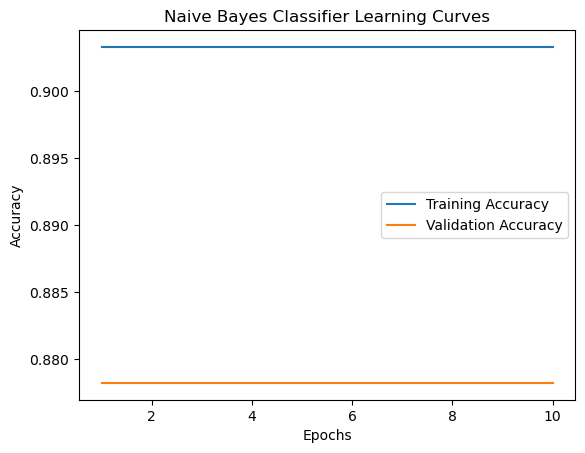

In [27]:
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Convert 'Poles' to a binary label (0 for Eastern, 1 for Western) for binary classification
label_mapping = {'Eastern': 0, 'Western': 1}
tokenized_nationality_eng['label'] = tokenized_nationality_eng['Poles'].map(label_mapping)

# Initialize lists to store performance metrics
train_accuracies = []
val_accuracies = []

# Assuming 'eng_tokens' contains the tokenized text and 'label' contains the binary label
featuresets = [
    (FreqDist(word_tokenize(row['eng_tokens'])), row['label'])
    for _, row in tokenized_nationality_eng.iterrows()
]

# Split the data into training and validation sets
train_set, val_set = train_test_split(featuresets, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier
classifier = NaiveBayesClassifier.train(train_set)

# Training loop
epochs = 10  # Adjust the number of epochs as needed
for epoch in range(epochs):
    # Evaluate on training set
    train_predictions = [classifier.classify(features) for features, _ in train_set]
    train_accuracy = accuracy_score([label for _, label in train_set], train_predictions)
    train_accuracies.append(train_accuracy)
    
    # Evaluate on validation set
    val_predictions = [classifier.classify(features) for features, _ in val_set]
    val_accuracy = accuracy_score([label for _, label in val_set], val_predictions)
    val_accuracies.append(val_accuracy)

    # Retrain the model with the entire training set
    classifier = NaiveBayesClassifier.train(train_set)

# Plotting the learning curves
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies[:epochs], label='Validation Accuracy')  # Ensure lengths match
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier Learning Curves')
plt.legend()
plt.show()


### Trying with Sneha's dataset:

#### Hyperparameter tuning with smoothing:
Laplace (add-one) smoothing

In [43]:
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from nltk.probability import LaplaceProbDist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'eng_tokens' contains the tokenized text and 'label' contains the binary label
featuresets = [
    (FreqDist(word_tokenize(row['eng_tokens'])), row['label'])
    for _, row in tokenized_nationality_balanced.iterrows()
]

# Split the data into training and validation sets
train_set, val_set = train_test_split(featuresets, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier with Laplace smoothing
classifier = NaiveBayesClassifier.train(train_set, estimator=LaplaceProbDist)

# Evaluate on validation set
val_predictions = [classifier.classify(features) for features, _ in val_set]
val_accuracy = accuracy_score([label for _, label in val_set], val_predictions)

print(f"Validation Accuracy: {val_accuracy}")


Validation Accuracy: 0.7140087251575375


Thus, 71.4% of the instances in the validation set were classified correctly by the NB trained model.

#### Cross validation: 
k-fold cross-validation and returns the accuracy for each fold

In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

# Assuming 'eng_tokens' contains the tokenized text and 'label' contains the binary label
X = tokenized_nationality_balanced['eng_tokens']
y = tokenized_nationality_balanced['label']

# Create a pipeline with CountVectorizer and Multinomial Naive Bayes
model = make_pipeline(CountVectorizer(), MultinomialNB())

# Perform 5-fold cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Accuracy:", cross_val_scores.mean())


Cross-Validation Scores: [0.8763936  0.83874616 0.81108597 0.82563025 0.77650291]
Mean Accuracy: 0.8256717795809922


#### Fine-Tune Training Duration:
To fine-tune the training duration, modifying the number of training epochs. 

In [48]:
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'eng_tokens' contains the tokenized text and 'label' contains the binary label
featuresets = [
    (FreqDist(word_tokenize(row['eng_tokens'])), row['label'])
    for _, row in tokenized_nationality_balanced.iterrows()
]

# Split the data into training and validation sets
train_set, val_set = train_test_split(featuresets, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier
classifier = NaiveBayesClassifier.train(train_set)

# Training loop with variable epochs
epochs_range = [5, 10, 15, 20]
for epochs in epochs_range:
    # Train the model for the specified number of epochs
    classifier = NaiveBayesClassifier.train(train_set)
    
    # Evaluate on validation set
    val_predictions = [classifier.classify(features) for features, _ in val_set]
    val_accuracy = accuracy_score([label for _, label in val_set], val_predictions)
    
    print(f"Epochs: {epochs}, Validation Accuracy: {val_accuracy}")


Epochs: 5, Validation Accuracy: 0.7198254968492487
Epochs: 10, Validation Accuracy: 0.7198254968492487
Epochs: 15, Validation Accuracy: 0.7198254968492487
Epochs: 20, Validation Accuracy: 0.7198254968492487


can try with more epochs

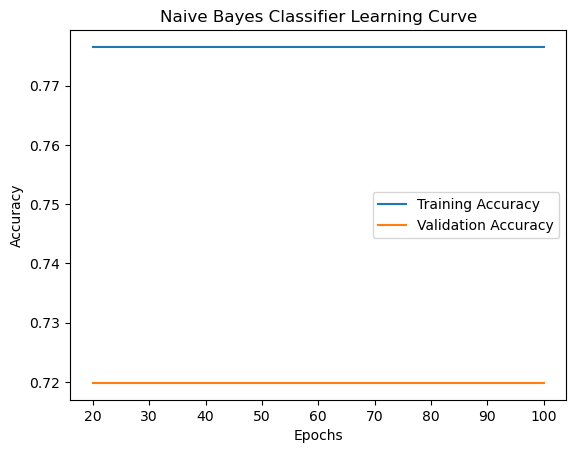

In [51]:
import matplotlib.pyplot as plt

# Initialize the Naive Bayes classifier
classifier = NaiveBayesClassifier.train(train_set)

# Training loop with variable epochs
epochs_range = [20,40,60,80,100] ## CAN INCREASE NUMBER OF EPOCHS GREATLY TO SEE CHANGE OVER TIME 
train_accuracies = []
val_accuracies = []

## EXAMINE BATCH SIZE 
for epochs in epochs_range:
    # Train the model for the specified number of epochs
    for _ in range(epochs):
        classifier = NaiveBayesClassifier.train(train_set)

    # Evaluate on training set
    train_predictions = [classifier.classify(features) for features, _ in train_set]
    train_accuracy = accuracy_score([label for _, label in train_set], train_predictions)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    val_predictions = [classifier.classify(features) for features, _ in val_set]
    val_accuracy = accuracy_score([label for _, label in val_set], val_predictions)
    val_accuracies.append(val_accuracy)

# Plotting the learning curves
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier Learning Curve')
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import matthews_corrcoef
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef([label for _, label in val_set], val_predictions)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Matthews Correlation Coefficient: {mcc}')

Validation Accuracy: 0.7198254968492487
Matthews Correlation Coefficient: 0.5253718937670623
